In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load the data
data_path = './data/balanced_label_encoded_scaled_data.csv'  # Replace with the correct path
data = pd.read_csv(data_path)

# Remove unnecessary columns
data = data.drop(['dropout.semester'], axis=1)

# Verify the nature of the target variable
target_column = 'retention'
y = data[target_column]

# If 'retention' is not categorical, convert it
if y.dtype != 'object' and len(y.unique()) > 20:
    y = (y > y.median()).astype(int)  # Convert to binary based on the median

# Use LabelEncoder if 'retention' is categorical
y = LabelEncoder().fit_transform(y)

# Separate the features
X = data.drop(target_column, axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)

# Models to evaluate
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'NeuralNetwork': MLPClassifier(max_iter=1000, random_state=42)
}

# Training and evaluating models
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Display the results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1_score']}")
    print("Classification Report:")
    print(metrics['classification_report'])
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print("\n" + "-"*60 + "\n")

# Hyperparameter tuning using GridSearchCV for the best model
param_grid = {
    'DecisionTree': {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10]
    },
    'NeuralNetwork': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd']
    }
}

best_model = None
best_score = 0

for model_name, params in param_grid.items():
    grid_search = GridSearchCV(models[model_name], params, cv=5, scoring='f1', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1 Score: {grid_search.best_score_}")

    if grid_search.best_score_ > best_score:
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_

# Evaluate the best model on the test set
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print("Best Model Performance on Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best)}")
print(f"Precision: {precision_score(y_test, y_pred_best)}")
print(f"Recall: {recall_score(y_test, y_pred_best)}")
print(f"F1 Score: {f1_score(y_test, y_pred_best)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))


Model: DecisionTree
Accuracy: 0.9654626564973378
Precision: 1.0
Recall: 0.9309253129946755
F1 Score: 0.9642271575495603
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6949
           1       1.00      0.93      0.96      6949

    accuracy                           0.97     13898
   macro avg       0.97      0.97      0.97     13898
weighted avg       0.97      0.97      0.97     13898

Confusion Matrix:
[[6949    0]
 [ 480 6469]]

------------------------------------------------------------

Model: NeuralNetwork
Accuracy: 0.9362498201180026
Precision: 0.9866752287686628
Recall: 0.8844438048640092
F1 Score: 0.9327667324328426
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6949
           1       0.99      0.88      0.93      6949

    accuracy                           0.94     13898
   macro avg       0.94      0.94      0.94  

In [5]:

# Load the new data from the same file
new_data = pd.read_csv('./data/label_encoded_scaled_data.csv')

new_data = new_data.drop(['dropout.semester'], axis=1)

# Remove the 'retention' column from the new data
X_new = new_data.drop('retention', axis=1)

# Scale the features using the same scaler used during training
X_new_scaled = scaler.transform(X_new)  # Assuming 'scaler' is the scaler used during training

# Apply PCA transformation to the scaled features
X_new_pca = pca.transform(X_new_scaled)  # Assuming 'pca' is the PCA model fitted during training

# Predict retention status using the pre-trained model
predicted_retention_status = best_model.predict(X_new_pca)  # Assuming 'best_model' is the trained classifier

# Interpret the predictions
# Assuming 1 indicates retention and 0 indicates dropout
retained_students = new_data[predicted_retention_status == 1]
dropout_students = new_data[predicted_retention_status == 0]

# Calculate the percentage of retained and dropout students
percentage_retained = (len(retained_students) / len(new_data)) * 100
percentage_dropout = (len(dropout_students) / len(new_data)) * 100

print(f"Percentage of Retained Students: {percentage_retained:.2f}%")
print(f"Percentage of Dropout Students: {percentage_dropout:.2f}%")


Percentage of Retained Students: 93.49%
Percentage of Dropout Students: 6.51%


[2.68007838e-13 6.49842402e-11 1.47702688e-07 ... 1.30853106e-11
 2.16077625e-06 9.99870071e-01]


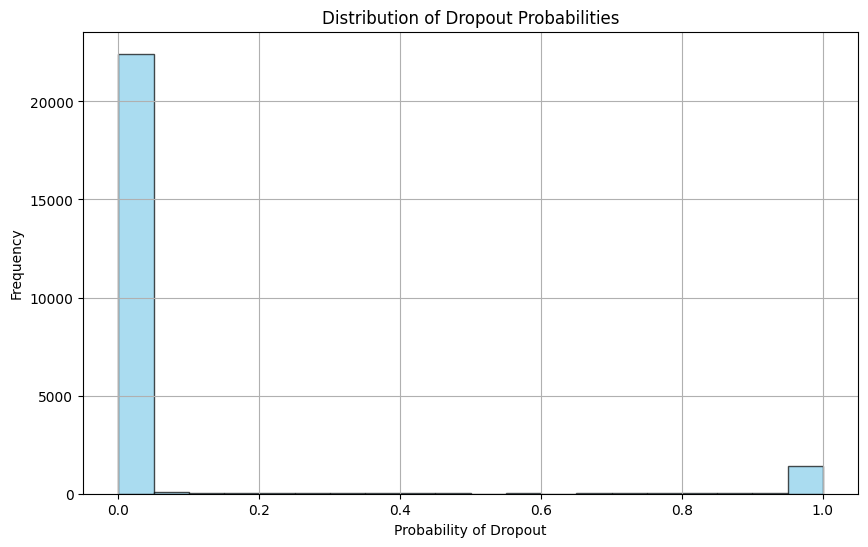

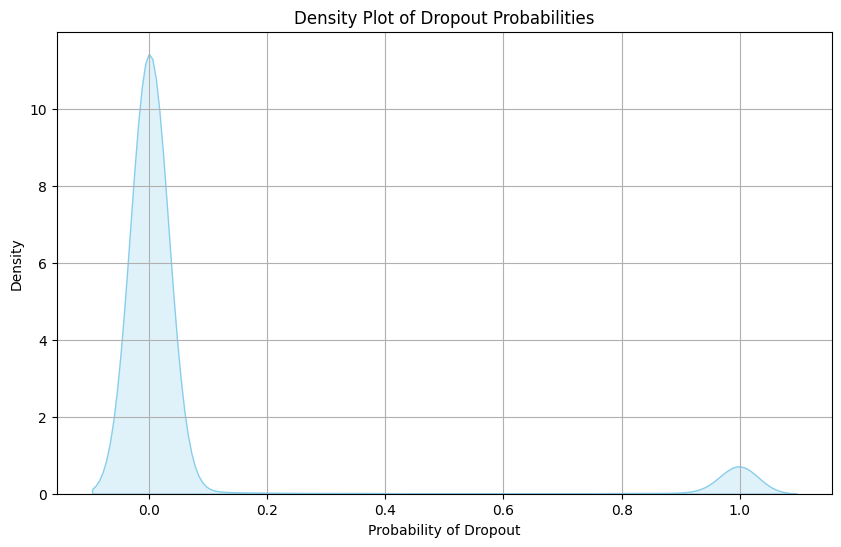

In [6]:
# Predict probability of dropout using the pre-trained model
dropout_probabilities = best_model.predict_proba(X_new_pca)[:,0]  # Probability of dropout (class 0)


# Assuming dropout_probabilities is an array containing the probability of dropout for each student
# You can print or analyze these probabilities to understand the likelihood of dropout for each student
print(dropout_probabilities)

import matplotlib.pyplot as plt

# Plot a histogram of dropout probabilities
plt.figure(figsize=(10, 6))
plt.hist(dropout_probabilities, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Dropout Probabilities')
plt.xlabel('Probability of Dropout')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

import seaborn as sns

# Plot a density plot of dropout probabilities
plt.figure(figsize=(10, 6))
sns.kdeplot(dropout_probabilities, color='skyblue', fill=True)
plt.title('Density Plot of Dropout Probabilities')
plt.xlabel('Probability of Dropout')
plt.ylabel('Density')
plt.grid(True)
plt.show()


The dropout probability for student 332 is: 0.9997160965122404


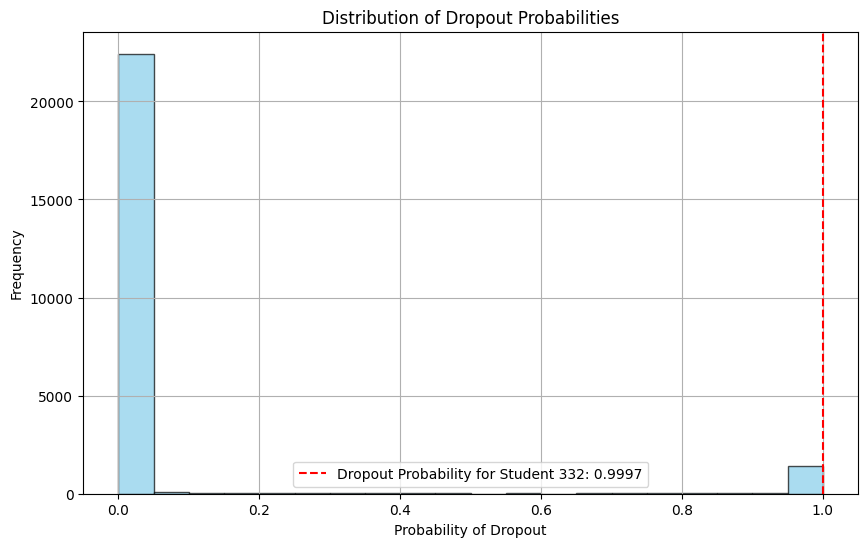

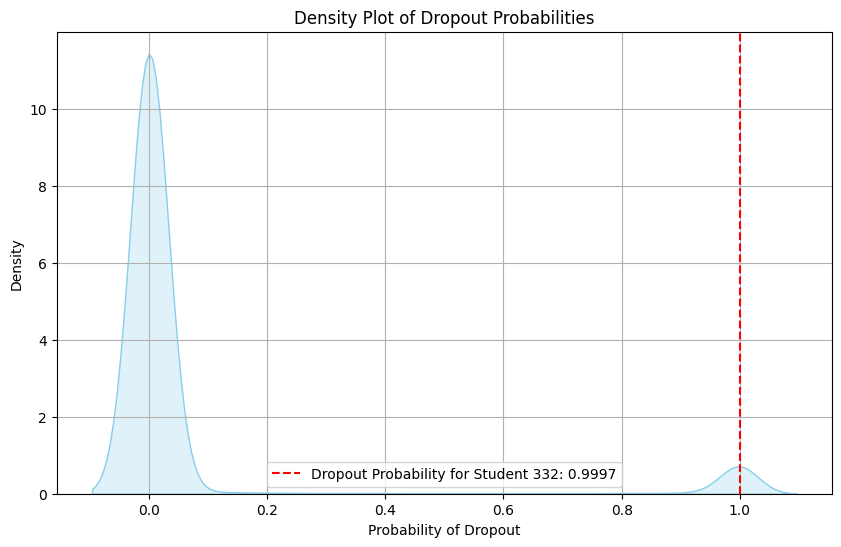

The dropout probability for student 332 is: 0.9996609588770028


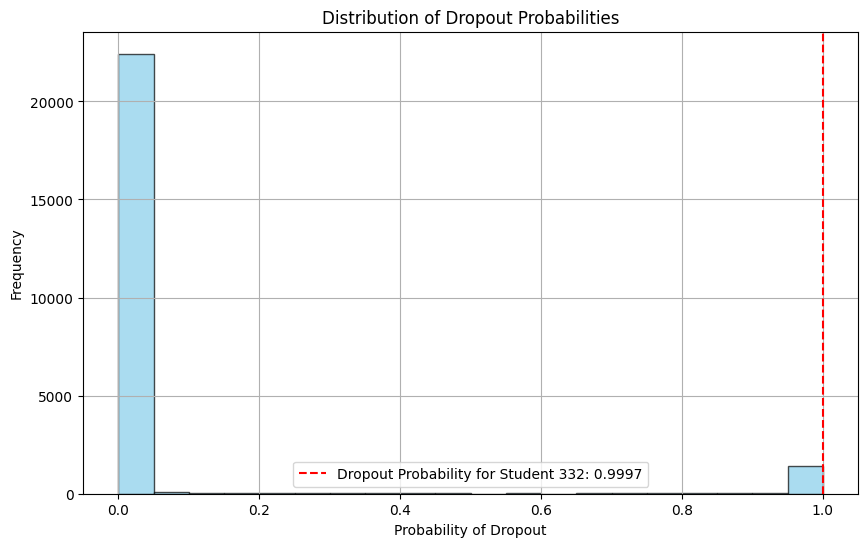

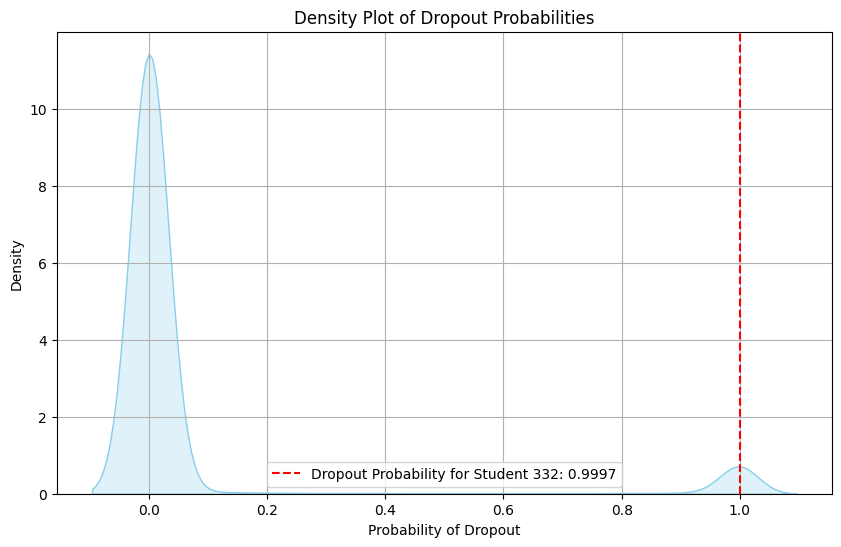

The dropout probability for student 332 is: 0.0004793135603640142


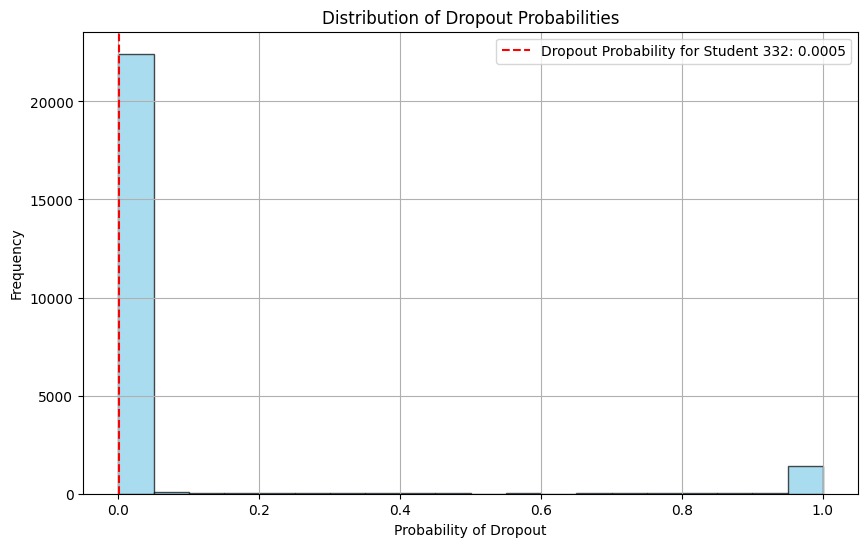

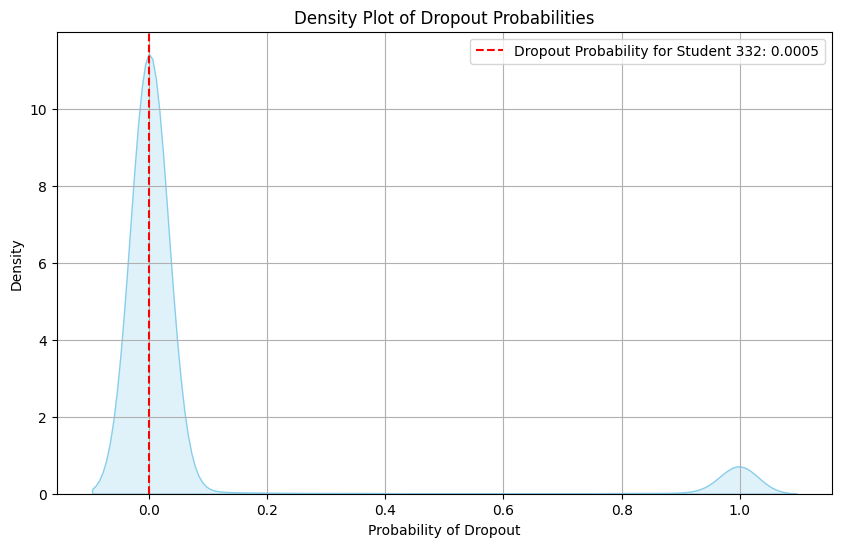

The dropout probability for student 332 is: 0.9995362284630649


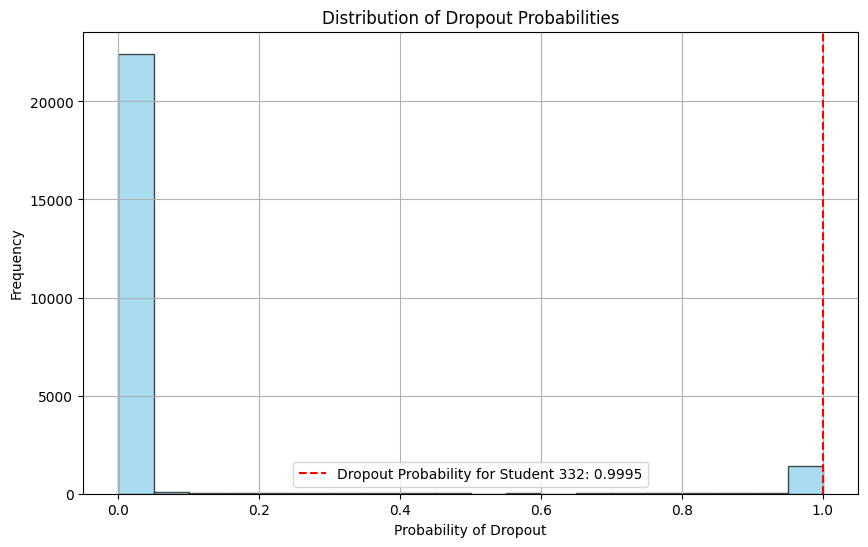

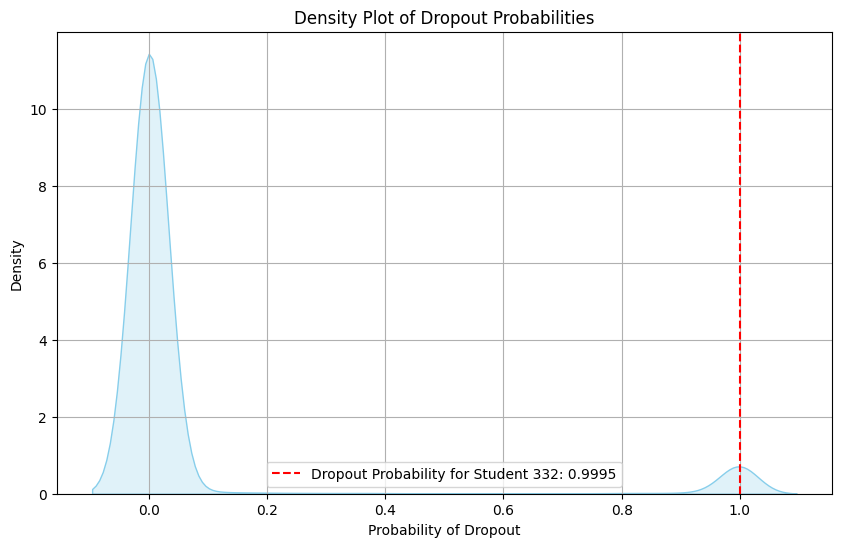

The dropout probability for student 332 is: 0.0007319313511233716


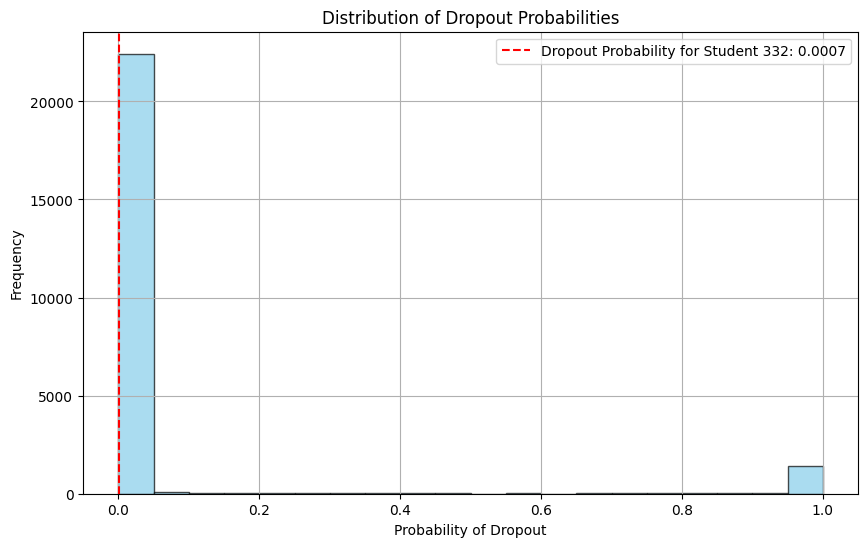

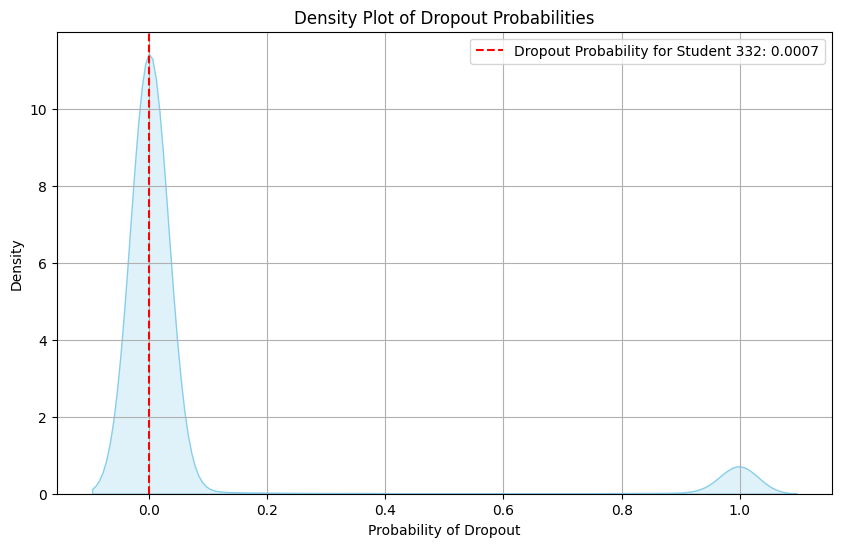

The dropout probability for student 332 is: 1.148373629522581e-08


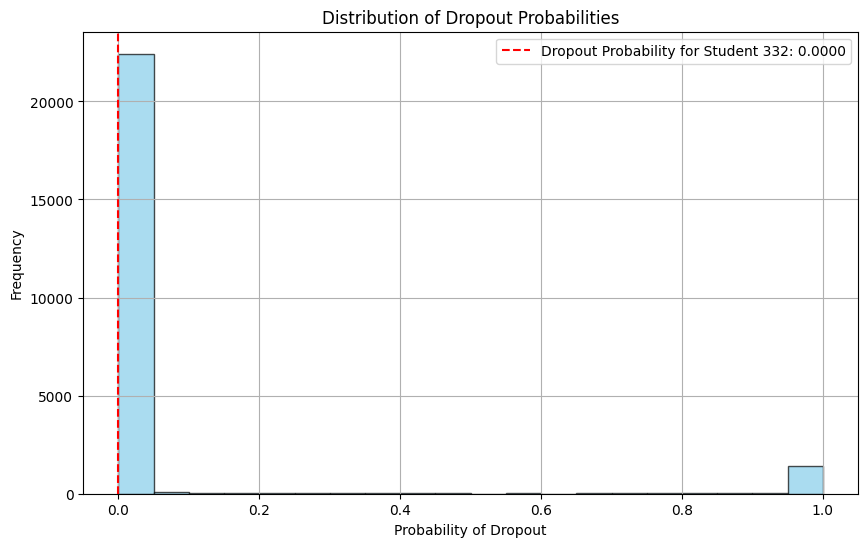

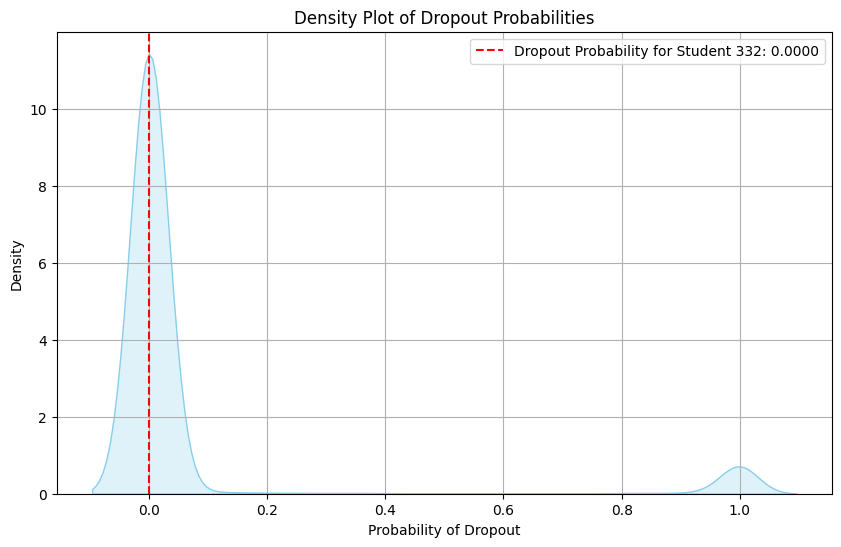

The dropout probability for student 332 is: 2.713301361367826e-09


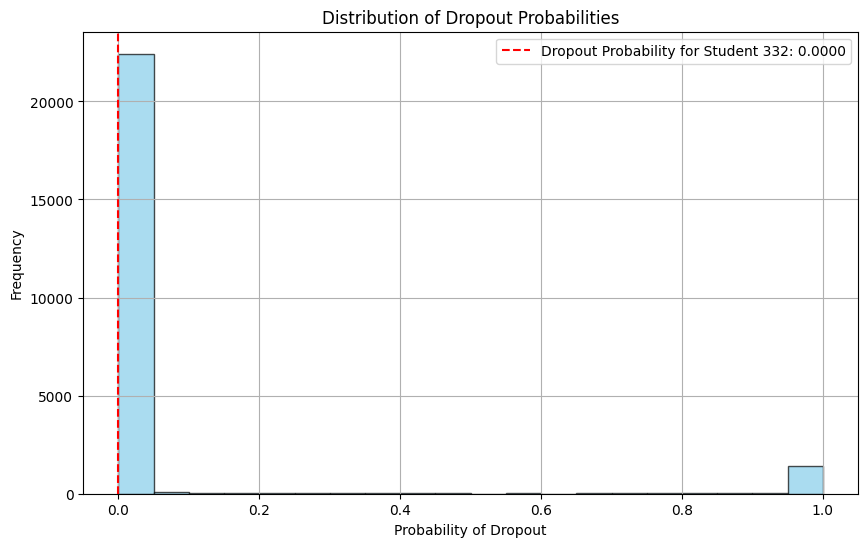

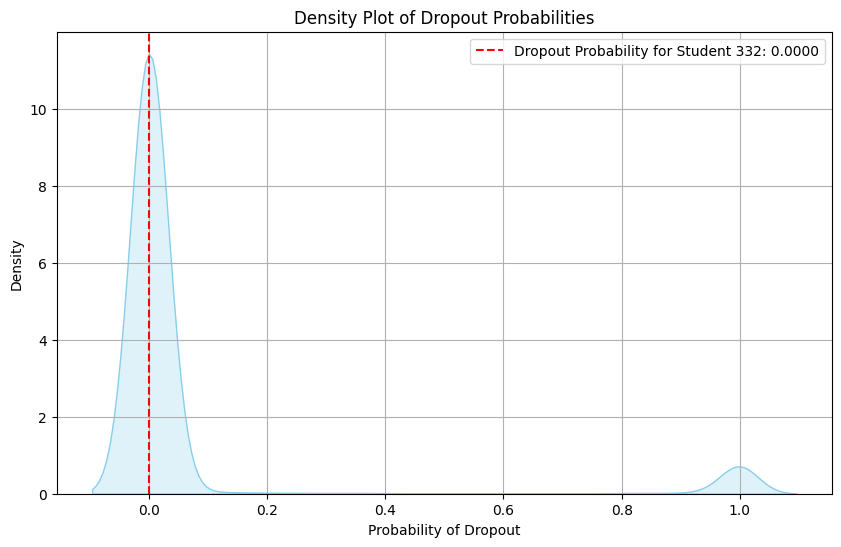

The dropout probability for student 332 is: 2.1055379662016094e-11


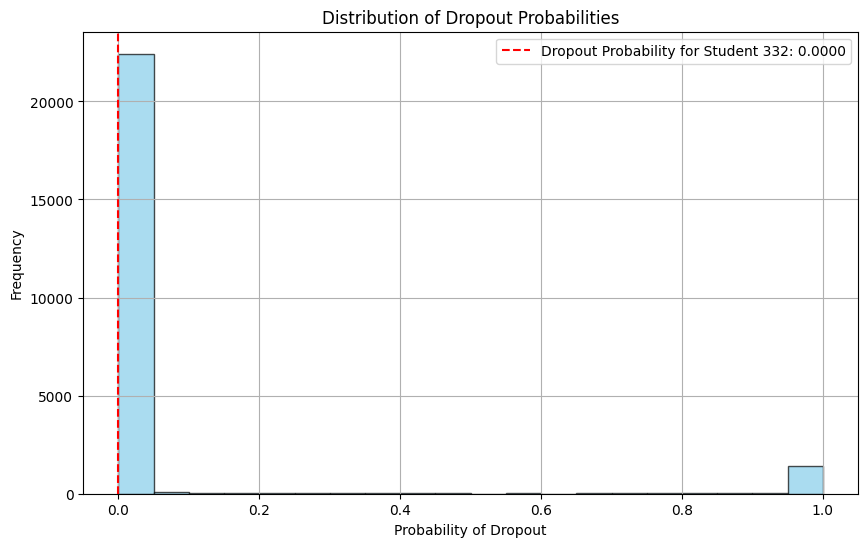

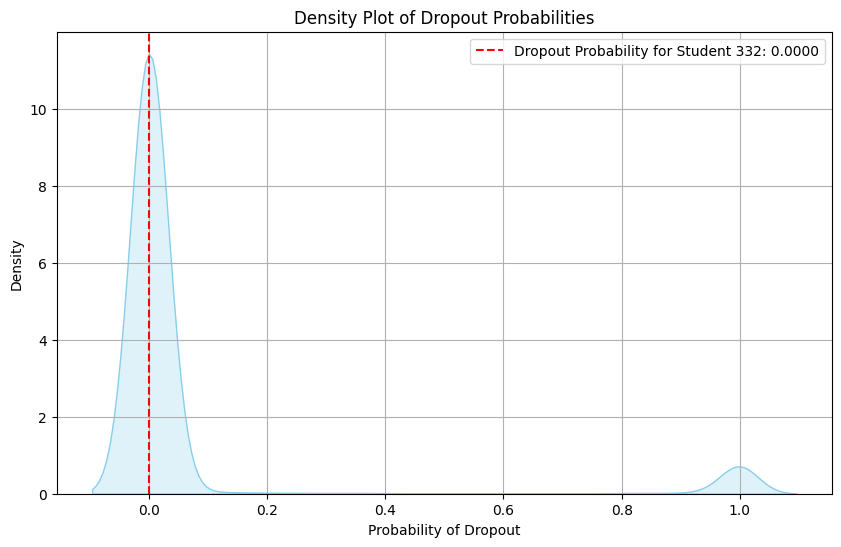

The dropout probability for student 332 is: 1.5013589482748557e-08


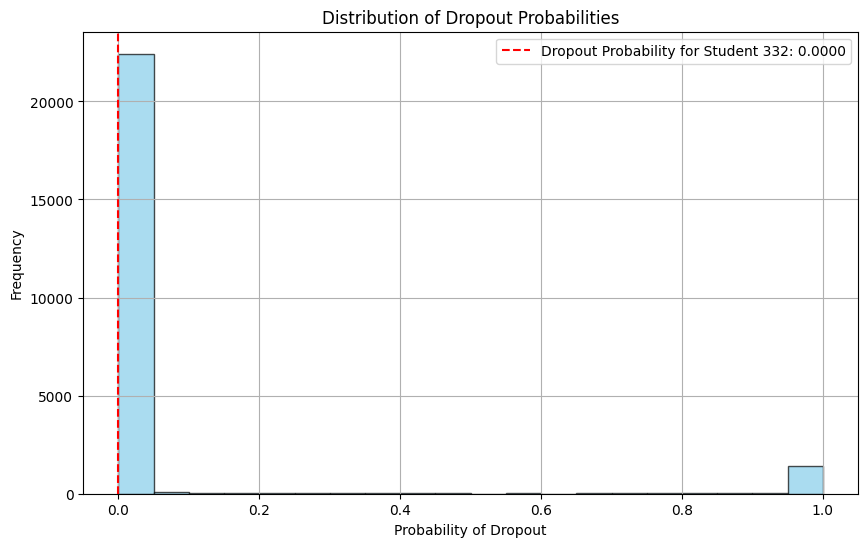

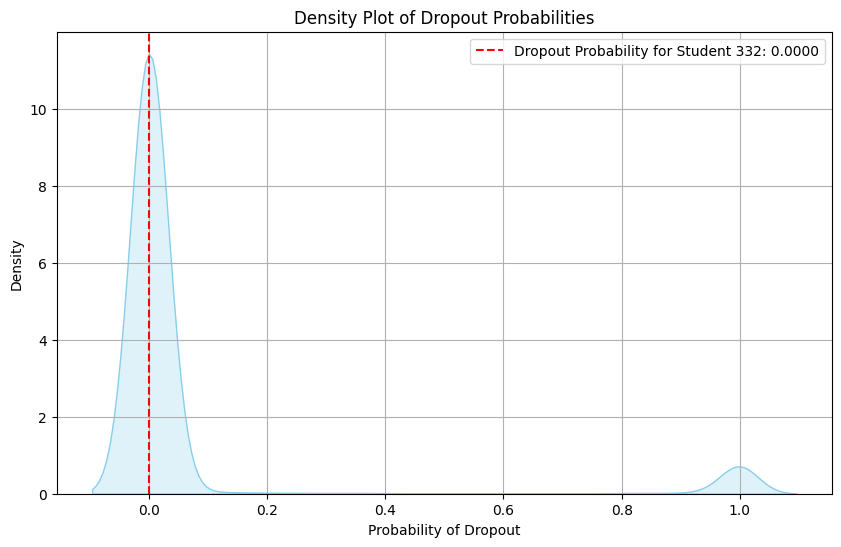

The dropout probability for student 332 is: 4.437880063434818e-09


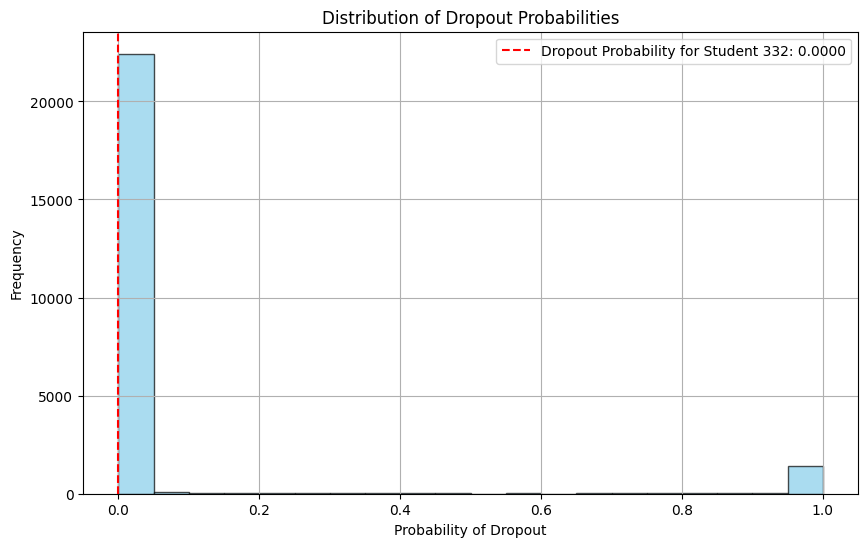

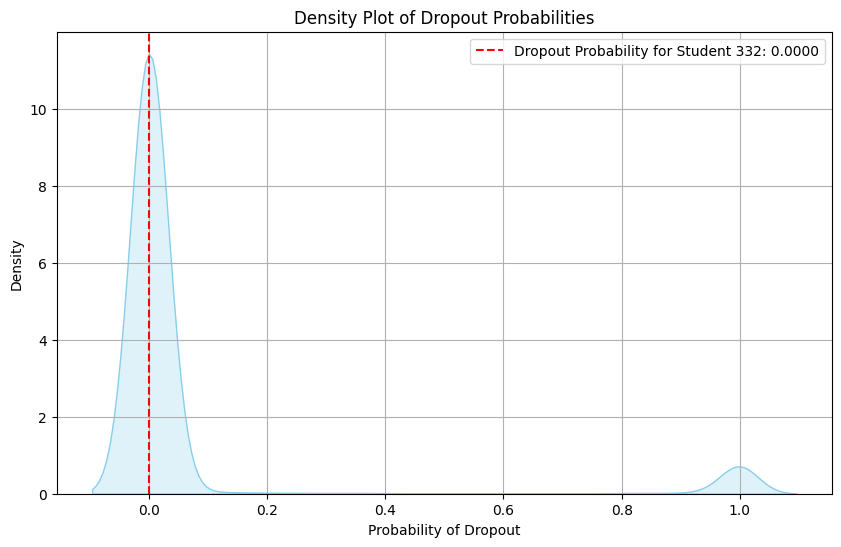

In [7]:
# Retrieve the dropout probability for the student at index 


for i in range(300, 310):
    dropout_probability_student_332 = dropout_probabilities[i]  # Assuming the index of student 332 is 332

    print(f"The dropout probability for student 332 is: {dropout_probability_student_332}")

    # Plot a histogram of dropout probabilities
    plt.figure(figsize=(10, 6))
    plt.hist(dropout_probabilities, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=dropout_probability_student_332, color='red', linestyle='--', label=f'Dropout Probability for Student 332: {dropout_probability_student_332:.4f}')
    plt.title('Distribution of Dropout Probabilities')
    plt.xlabel('Probability of Dropout')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot a density plot of dropout probabilities
    plt.figure(figsize=(10, 6))
    sns.kdeplot(dropout_probabilities, color='skyblue', fill=True)
    plt.axvline(x=dropout_probability_student_332, color='red', linestyle='--', label=f'Dropout Probability for Student 332: {dropout_probability_student_332:.4f}')
    plt.title('Density Plot of Dropout Probabilities')
    plt.xlabel('Probability of Dropout')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
